# Часть II: О линейной регрессии


# Пункт 1
Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания). Иначе говоря, мы будем “играть” за российские власти, которые пытаются понять, что делать, глядя на данные об эпидемии в мае 2020 года.

In [272]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
legend_fontsize = 16

In [237]:
data_covid = pd.read_csv("owid-covid-data.csv")

In [238]:
ru_data_covid = data_covid[(data_covid.location=="Russia") & (data_covid.date >="2020-03-03")]

In [239]:
ru_data_covid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
52760,RUS,Europe,Russia,2020-03-03,3.0,0.0,0.143,NaN,NaN,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
52761,RUS,Europe,Russia,2020-03-04,3.0,0.0,0.143,NaN,NaN,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
52762,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
52763,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
52764,RUS,Europe,Russia,2020-03-07,13.0,0.0,1.571,NaN,NaN,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824


In [240]:
ru_data_covid.reset_index(inplace=True)
ru_data_covid.drop('index', 1, inplace=True)
ru_data_covid.index = np.array(range(1, ru_data_covid.shape[0] + 1))
ru_data_covid.reset_index(inplace=True)

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [241]:
ru_data_covid.head()

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,1,RUS,Europe,Russia,2020-03-03,3.0,0.0,0.143,NaN,NaN,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
1,2,RUS,Europe,Russia,2020-03-04,3.0,0.0,0.143,NaN,NaN,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
2,3,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
3,4,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824
4,5,RUS,Europe,Russia,2020-03-07,13.0,0.0,1.571,NaN,NaN,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.824


In [242]:
ru_data_covid.index

RangeIndex(start=0, stop=360, step=1)

In [243]:
ru_data_covid['new_cases'] = ru_data_covid['new_cases'].apply(lambda x: 1 if x == 0 else x)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [244]:
train = ru_data_covid.iloc[:50,:]
test = ru_data_covid.iloc[50:,:]

# Пункт 2
Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

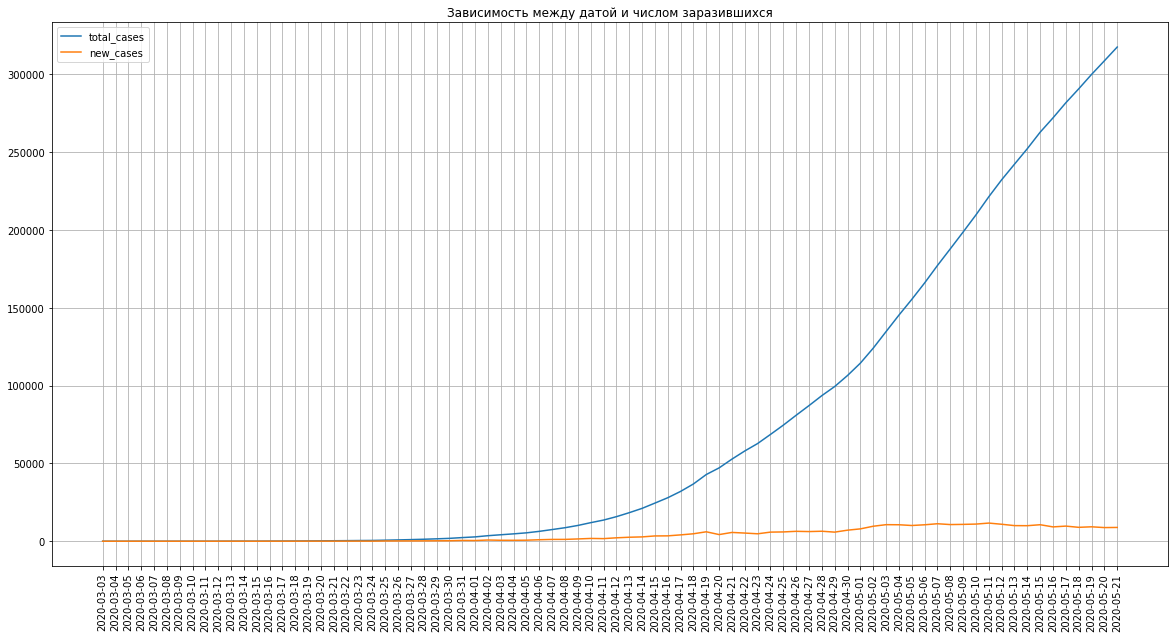

In [245]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Зависимость между датой и числом заразившихся')
ax.plot(ru_data_covid.date[:80],
        ru_data_covid.total_cases[:80],
        color='tab:blue', label="total_cases")
ax.plot(ru_data_covid.date[:80],
        ru_data_covid.new_cases[:80],
        color='tab:orange', label="new_cases")
plt.xticks(rotation=90)
plt.grid()
plt.legend()
plt.show()

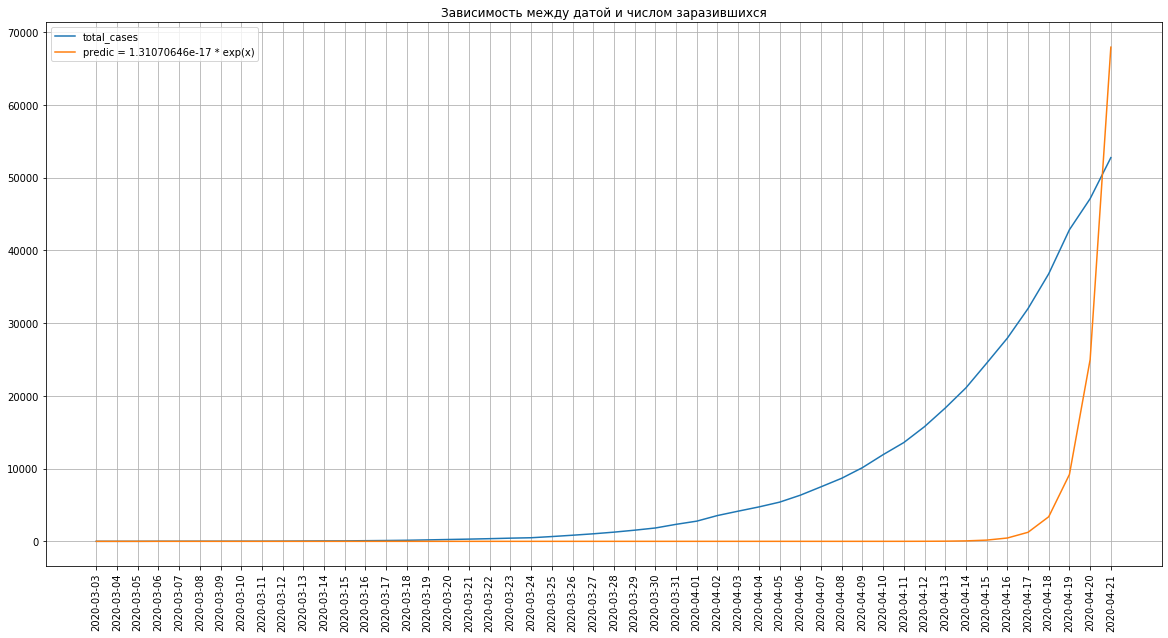

In [246]:
alpha = 1
reg = LinearRegression(fit_intercept=False)
reg.fit(np.exp(alpha * train.index.values).reshape(-1, 1), train.total_cases.values)
pred = reg.predict(np.exp(alpha * ru_data_covid.index.values).reshape(-1, 1))

lim = 50
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Зависимость между датой и числом заразившихся')
ax.plot(ru_data_covid.date[:lim],
        ru_data_covid.total_cases[:lim],
        color='tab:blue', label="total_cases")
ax.plot(ru_data_covid.date[:lim],
        pred[:lim],
        color='tab:orange', label="predic = 1.31070646e-17 * exp(x)")
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

In [247]:
reg.coef_

array([3.56286956e-17])

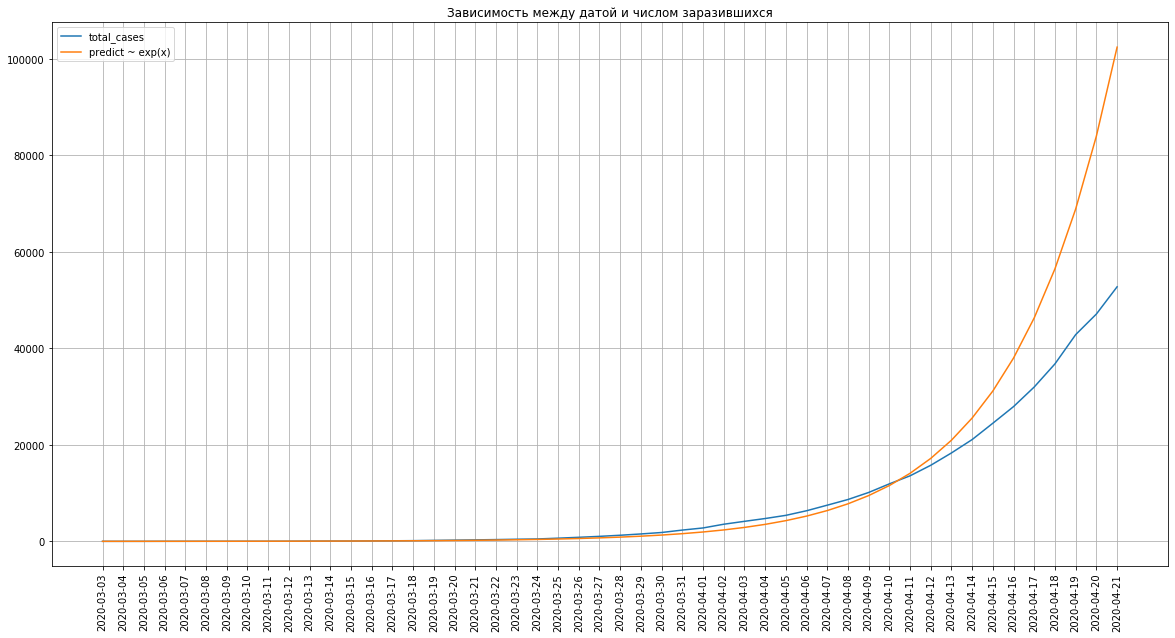

In [248]:
alpha = 1
reg = LinearRegression()
reg.fit(train.index.values.reshape(-1, 1), np.log(train.total_cases.values))
pred = reg.predict(ru_data_covid.index.values.reshape(-1, 1))

lim = 50
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Зависимость между датой и числом заразившихся')
ax.plot(ru_data_covid.date[:lim], ru_data_covid.total_cases.values[:lim],
        color='tab:blue', label="total_cases")
ax.plot(ru_data_covid.date[:lim], np.exp(pred[:lim]),
        color='tab:orange', label="predict ~ exp(x)")
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

In [249]:
reg.coef_, reg.intercept_

(array([0.19829091]), 1.820737148784695)

Как видим получилось относительно неплохо 

In [250]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[i, 1] for i in x])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), y) ) 
    return mu_n, sigma_n

In [251]:
pred = reg.predict(train.index.values.reshape(-1, 1))
sn = np.std(np.log(train.total_cases.values) - pred, dtype="float64")

In [252]:
cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])
mu, sigma = bayesian_update(cur_mu, cur_sigma, train.index.values, np.log(train.total_cases.values), sigma_noise=sn)
mu, sigma

(array([0.19854949, 1.81219413]), array([[ 1.16594430e-05, -2.85308760e-04],
        [-2.85308760e-04,  9.41520326e-03]]))

In [334]:
# Посэмплируем прямые и выдадим статистики по предсказаниям
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.exp(w[0] + w[1]*xs)
    return res

# Нарисуем результат
figsize =(30, 10)
def plot_predictions(xs, mu, x):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((0, 75))
    ax.set_ylim((0, 1e5))
    #ax.plot(xs, train.total_cases.values, label="Правильный ответ")
    ax.plot(xs, np.exp(mu[0]*xs + mu[1]), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(mu[0]*xs + mu[1]- sn), np.exp(mu[0]*xs + mu[1]+ sn), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.exp(mu[0]*np.mean(x, axis=0) + mu[1] - np.std(x, axis=0)),
                    np.exp(mu[0]*np.mean(x, axis=0) + mu[1] + np.std(x, axis=0)), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    #ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


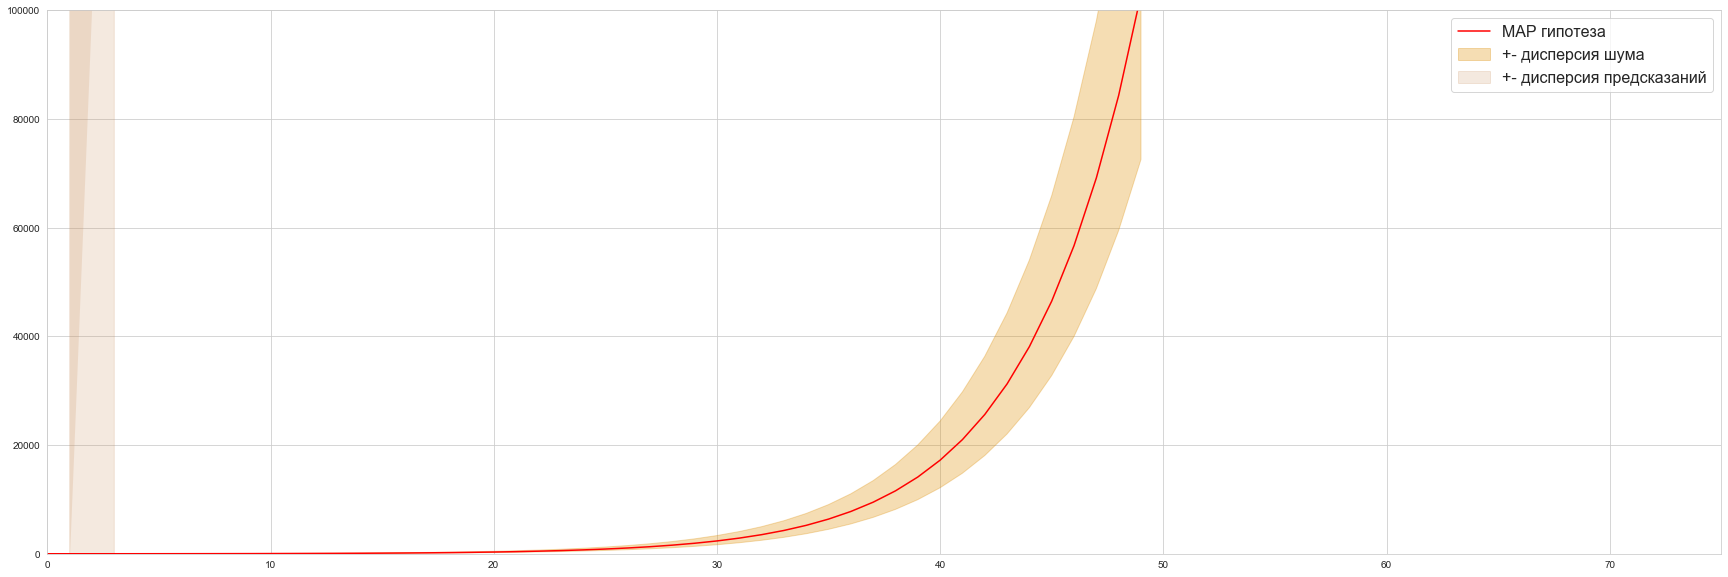

In [335]:
x = sample_statistics(mu, sigma, train.index.values, n=20)
plot_predictions(train.index.values, mu, x)

In [314]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    for w in my_w:
        plt.plot(xs, np.exp(w[1] + w[0]*xs), 'k-', lw=.4)
    plt.ylim((0, 1e5))
    plt.xlim((0, 75))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

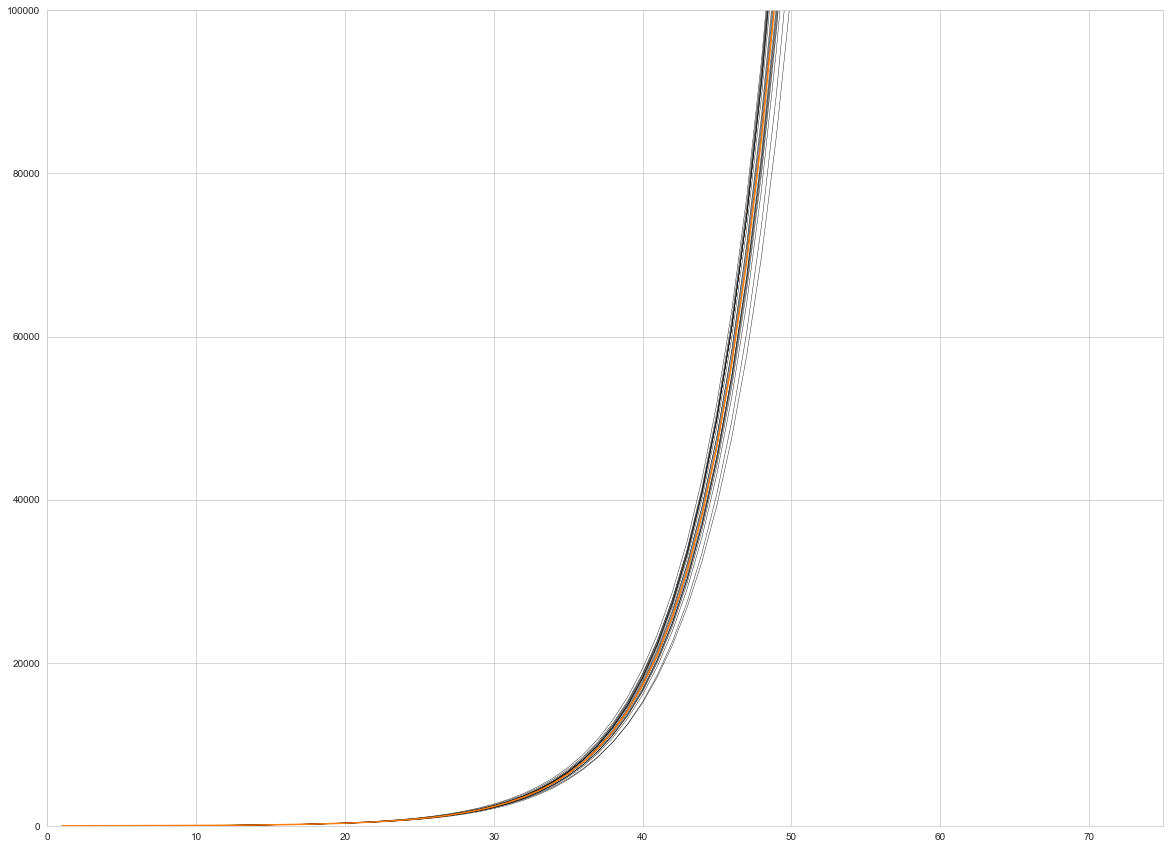

In [292]:
figsize =(20, 15)
fig = plt.figure(figsize=figsize)
xs = np.linspace(1, 75, 75)
myplot_sample_lines(mu, sigma)
plt.plot(xs, np.exp(mu[1] + mu[0]*xs), color='tab:orange')

# Пункт 3

In [350]:
new_x = np.array([[i**2, i] for i in range(1, ru_data_covid.shape[0] + 1)])

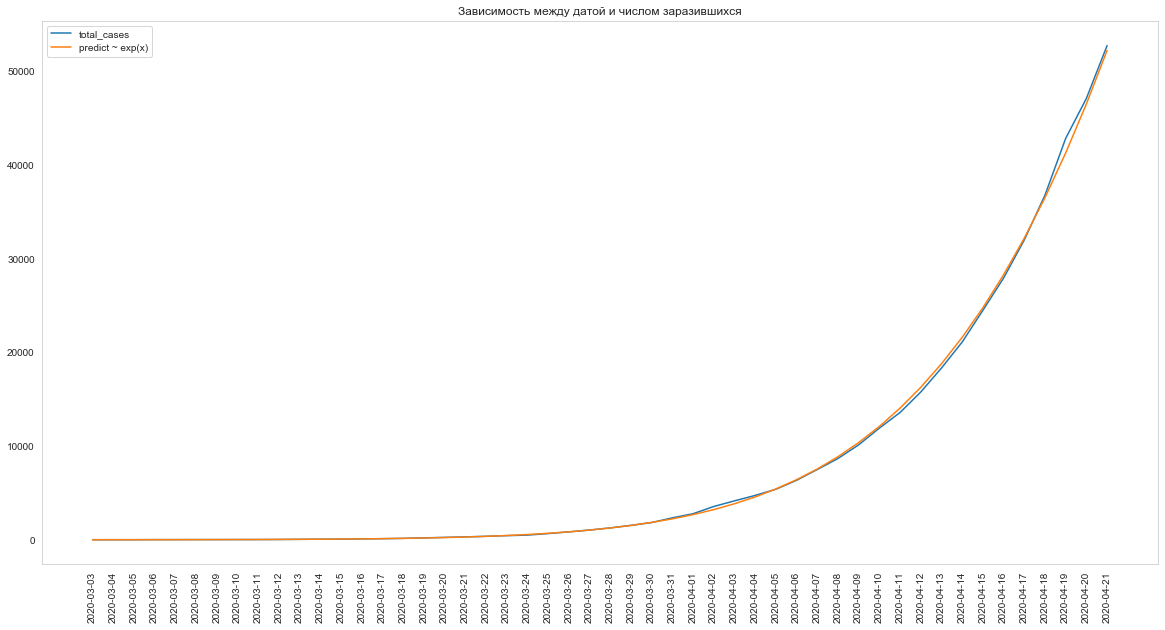

In [361]:
alpha = 1
reg = LinearRegression()
reg.fit(new_x[:50], np.log(train.total_cases.values))
pred = reg.predict(new_x)

lim = 50
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Зависимость между датой и числом заразившихся')
ax.plot(ru_data_covid.date[:lim], ru_data_covid.total_cases.values[:lim],
        color='tab:blue', label="total_cases")
ax.plot(ru_data_covid.date[:lim], np.exp(pred[:lim]),
        color='tab:orange', label="predict ~ exp(x)")
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

In [362]:
reg.coef_, reg.intercept_

(array([-0.00171767,  0.28589211]), 0.8632358736013375)

In [363]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[i**2, i, 1] for i in x])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), y) ) 
    return mu_n, sigma_n

In [364]:
sn = np.std(np.log(train.total_cases.values) - pred[:50], dtype="float64")
cur_mu, cur_sigma = np.array([0, 0, 0]), np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
mu, sigma = bayesian_update(cur_mu, cur_sigma, train.index.values, np.log(train.total_cases.values), sigma_noise=0.25)
mu, sigma

(array([-0.00173323,  0.28338455,  1.13584025]),
 array([[ 3.58711474e-08, -1.75561784e-06,  1.39933228e-05],
        [-1.75561784e-06,  9.19048862e-05, -8.31213671e-04],
        [ 1.39933228e-05, -8.31213671e-04,  1.02882731e-02]]))

In [374]:
# Посэмплируем прямые и выдадим статистики по предсказаниям
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = np.cumsum(np.exp(w[0]*(xs**2) + w[1]*xs + w[2]))
    return res

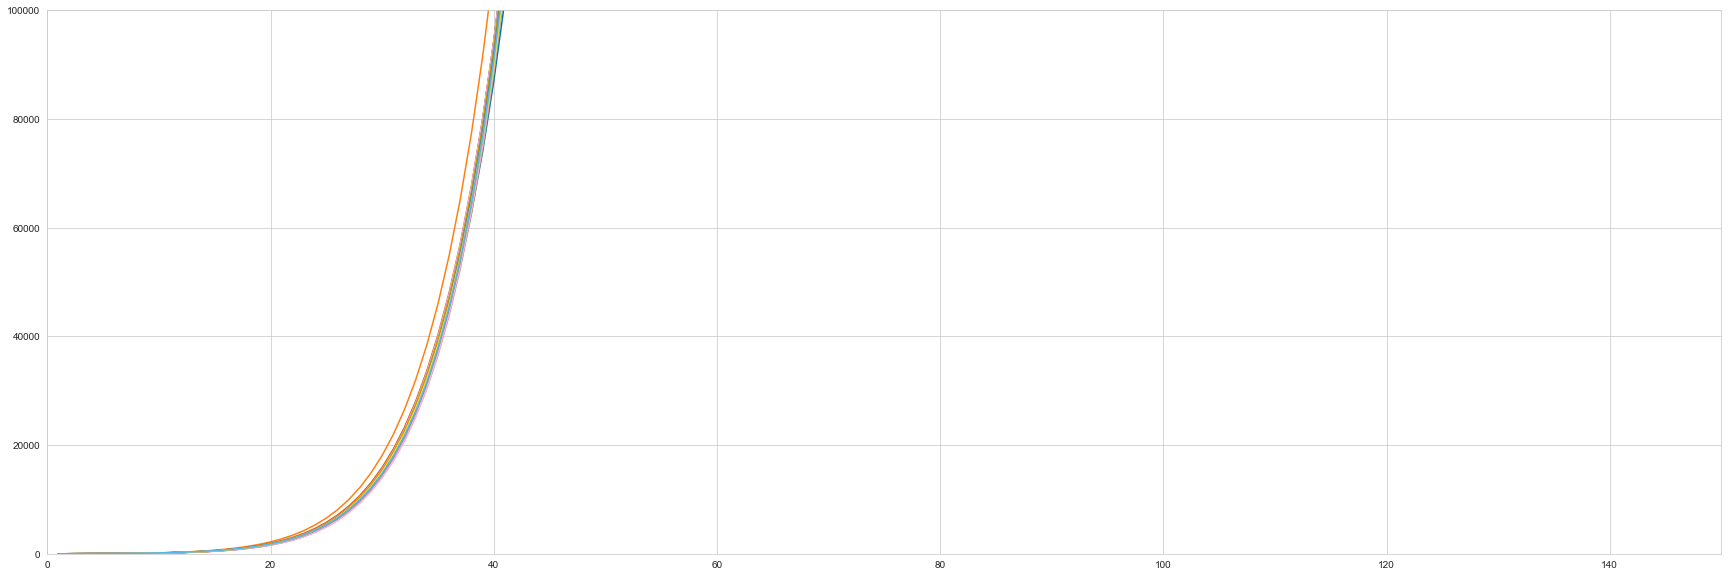

In [378]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((0, 150))
ax.set_ylim((0, 1e5))
xs = np.linspace(1, 150, 150)
x = sample_statistics(mu, sigma, ru_data_covid.index.values, n=20)
plt.plot(xs, np.cumsum(np.exp(mu[0]*(xs**2) + mu[1]*xs + mu[2])), color='tab:orange')
for i in x:
    plt.plot(xs, i[:150])